<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/season_3_episode_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Dataset

Данные (обучающая и тестовая выборки) для этого [соревнования](https://www.kaggle.com/competitions/playground-series-s3e1/data) были сгенерированы нейронной сетью, обученной на исходных данных [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). Распределения признаков близко к исходным.

У данных следующие признаки:

- `MedInc` медианный доход в переписном участке

- `HouseAge` медианный возраст дома в переписном участке

- `AveRooms` среднее количество комнат в доме 

- `AveBedrms` среднее количество спален в доме

- `Population` население переписного участка

- `AveOccup` среднее количество людей, проживающих в доме

- `Latitude` широта переписного участка

- `Longitude` долгота переписного участка

Переписной участок - наименьшая географическая единица, которая используется Бюро статистики США для публикации данных (в границах переписного участка обычно проживают от 600 до 3 000 человек).

Решение будет оцениваться по RMSE.

## Загрузка и анализ данных

Импортируем необходимые библиотеки и модули:

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aleksandrdel","key":"ce71447b29fc3486f60733eae1b877cd"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Загрузим обучающую и тестовую выборки:

In [17]:
! kaggle competitions download -c playground-series-s3e1

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 110MB/s]


Распакуем архивный файл:

In [20]:
! unzip playground-series-s3e1.zip -d data

Archive:  playground-series-s3e1.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


Сохраним обучающую выборку в переменной `df` и выведим первые 5 строк:

In [21]:
df = pd.read_csv('/content/data/train.csv')
df.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


Общая информация об обучающей выборке:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


В обучающей выборке 37 137 объектов, 8 признаков, `MedHouseVal` - целевой признак. Пропуски отсутствуют. Тип данных у всех признаков количественный.

В переменной `X` сохраним список признаков, в переменной `y` - название целевого признака:

In [28]:
X = df.drop(columns=['id', 'MedHouseVal']).columns.tolist()
X

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [29]:
y = 'MedHouseVal'
y

'MedHouseVal'

Посмотрим на распределения признаков:

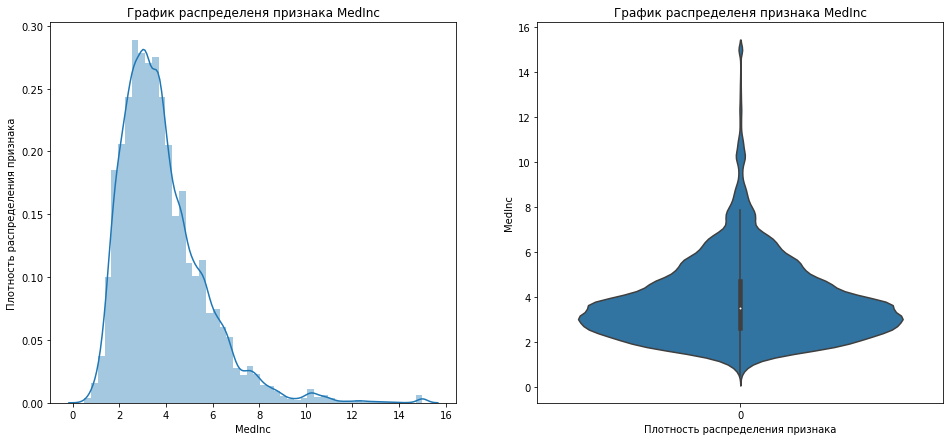

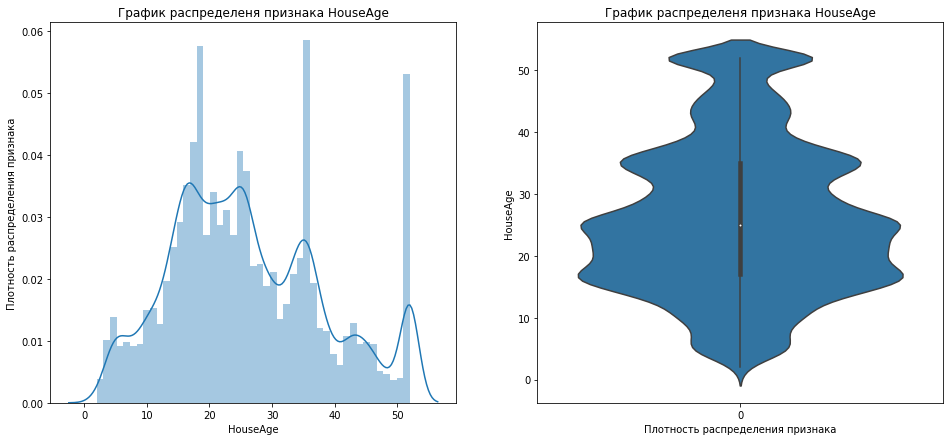

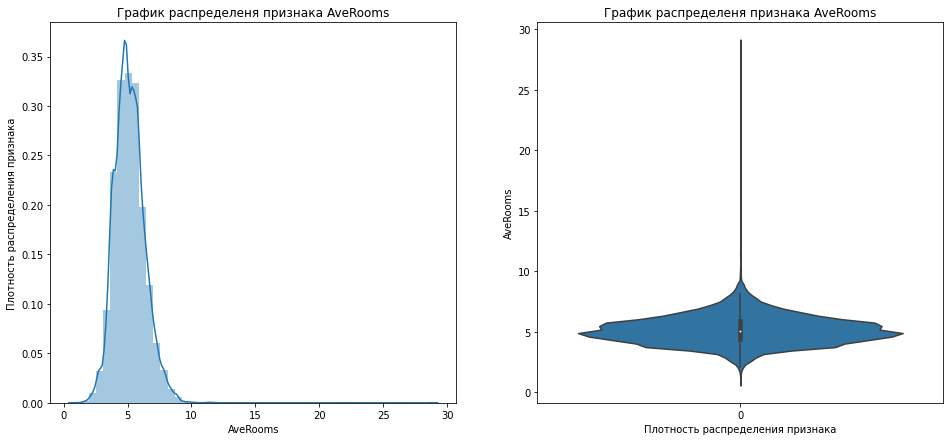

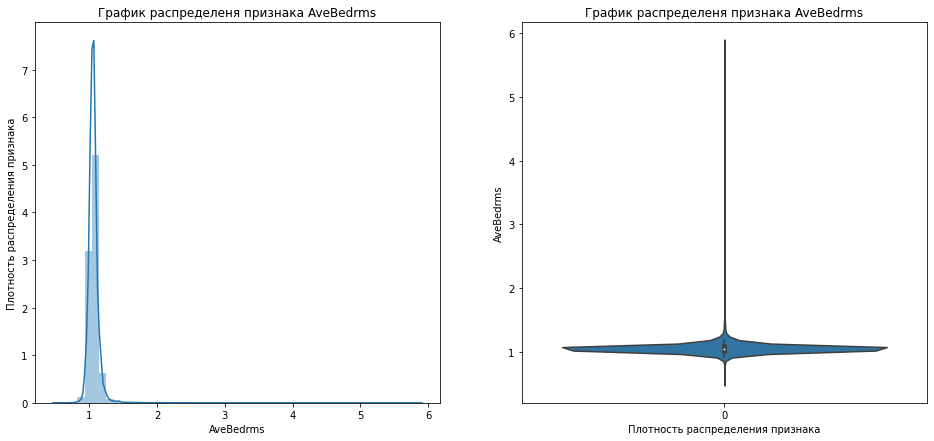

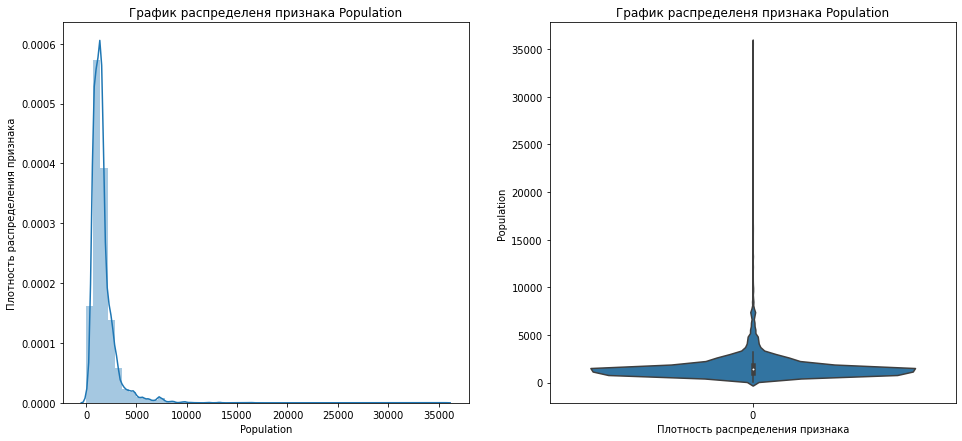

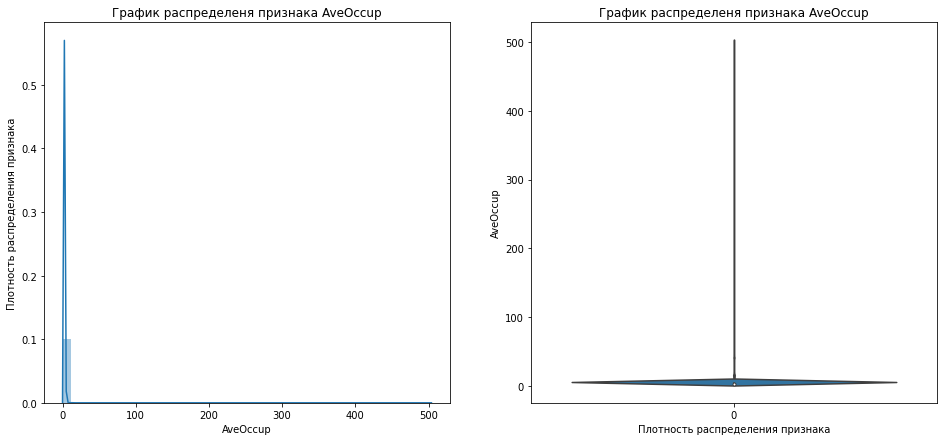

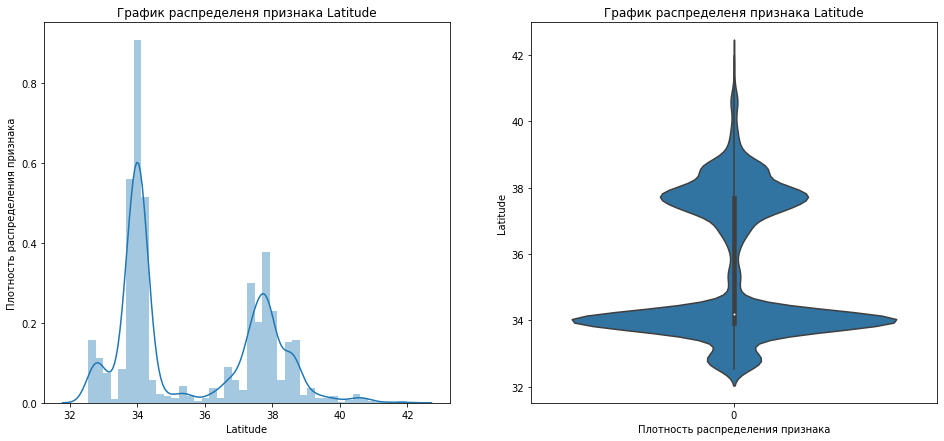

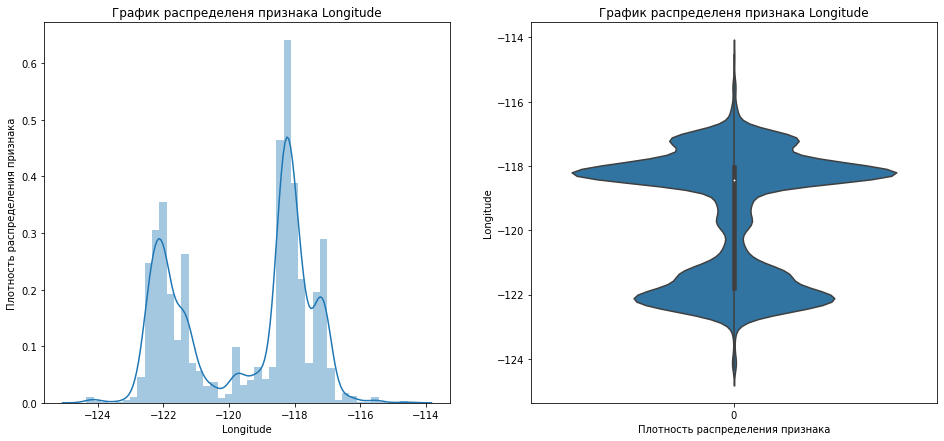

In [39]:
for i in range(len(X)):
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    sns.distplot(df[X[i]], ax=ax[0])
    ax[0].set(ylabel='Плотность распределения признака', 
              xlabel=f'{X[i]}', 
              title=f'График распределеня признака {X[i]}')
    sns.violinplot(df[X[i]], ax=ax[1])
    ax[1].set(ylabel=f'{X[i]}',
                xlabel='Плотность распределения признака', 
                title=f'График распределеня признака {X[i]}')
    plt.show();
    print()

Посмотрим на распределение целевого признака:

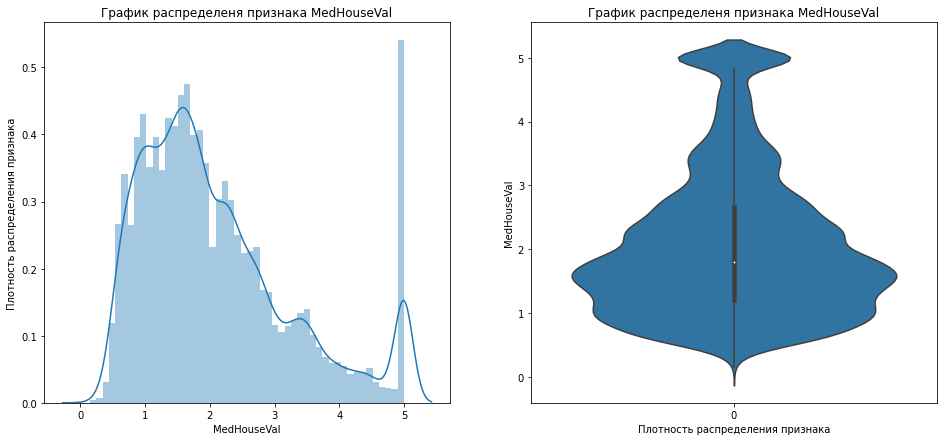

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sns.distplot(df[y], ax=ax[0])
ax[0].set(ylabel='Плотность распределения признака', 
          xlabel=y, 
          title=f'График распределеня признака {y}')
sns.violinplot(df[y], ax=ax[1])
ax[1].set(ylabel=y, 
          xlabel='Плотность распределения признака', 
          title=f'График распределеня признака {y}')
plt.show()

Описательная статистика:

In [42]:
df[X].describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329
std,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028
min,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000
25%,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000
50%,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000
75%,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000
max,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000


## Обучение моделей

### Линейная регрессия с регуляризацией Lasso

Инициализируем модель линейной регрессии:

In [69]:
lrl = Lasso(random_state=42)

Создадим сетку гиперпараметров, которые будем перебирать при обучении и кросс-валидации алгоритма линейной регрессии:

In [70]:
params = {'alpha': [0, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20],
          'max_iter': [300, 500, 1000, 2000, 5000]}

In [73]:
gs = GridSearchCV(lrl,
                  params,
                  scoring='neg_mean_squared_error',
                  cv=5,
                  n_jobs=2)

Перебирем гиперпараметры алгоритма линейной регрессии:

In [74]:
gs.fit(df[X], df[y])

GridSearchCV(cv=5, estimator=Lasso(random_state=42), n_jobs=2,
             param_grid={'alpha': [0, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20],
                         'max_iter': [300, 500, 1000, 2000, 5000]},
             scoring='neg_mean_squared_error')

Лучшие гиперпараметры модели линейной регресии:

In [75]:
gs.best_params_

{'alpha': 0.1, 'max_iter': 300}

Лучшая метрика RMSE модели линейной регрессии:

In [77]:
(-gs.best_score_) ** 0.5

0.8440781677061475

Посмотрим на величины весов признаков, обучив алгоритм `Lasso` на лучших гиперпараметрах модели. Чем больше по модулю вес признака, тем он важнее:

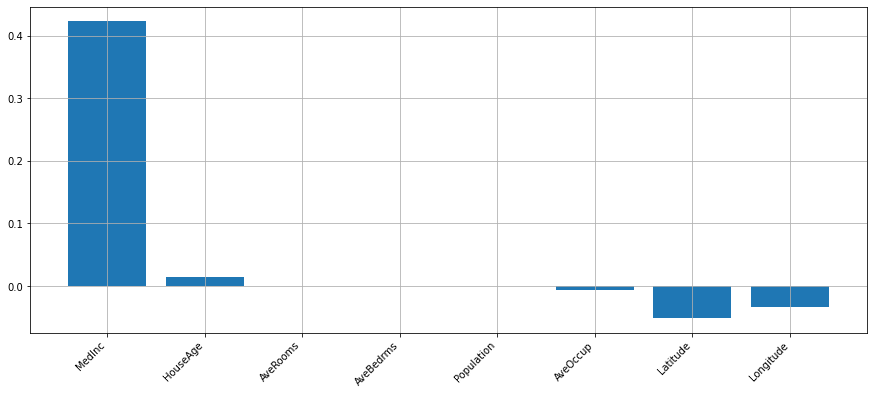

In [78]:
model = Lasso(random_state=42, alpha=0.1, max_iter=300)
model.fit(df[X], df[y])
plt.figure(figsize=(15, 6))
plt.bar(X, model.coef_)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

### Градиентный бустинг

Реализуем класс градиентного бустинга:

In [82]:
class MyGradientBoosting():
    def __init__(self, lr=0.01, iters=1000, max_depth=32):
        self.lr = lr
        self.iters = iters
        self.max_depth = max_depth
        self.models_ = None
        self.constant_prediction_ = None
        self.MSE_ = None

    def fit(self, X, y):
        X = X.values
        y = y.values
        prediction = np.full((y.shape), np.mean(y)) # инициализируем модель константным предсказанием: среднее значение таргета обучающей выборки
        models = [] # в этом списке будем хранить модели Решающего дерева
        MSE = [] # в этом списке будем хранить значение MSE каждой итерации

        for _ in range(self.iters):
            residual = y - prediction # считаем остатки
            model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42) # инициализируем модель Решающего дерева
            model.fit(X, residual) # обучаемся на остатках
            prediction += model.predict(X) * self.lr # корректируем константное предсказание, компенсируя остатки
            models.append(model) # сохраняем модель в список моделей
            MSE.append(mean_squared_error(y, prediction)) # сохраняем метрику MSE
           
        self.models_ = models
        self.constant_prediction_ = np.mean(y)
        self.MSE_ = MSE

    def predict(self, X):
        X = X.values
        prediction = np.full((X.shape[0]), self.constant_prediction_)

        for model in self.models_:
            prediction += model.predict(X) * self.lr
    
        return prediction

Так как класс `MyGradientBoosting` не принадлежит библиотеке `scikit-learn` и в нем не реализован метод `get_params`, кросс-валидацию градиентного бустинга проведем с помощью `KFold`, дополнительно будем перебирать гиперпараметр `max_depth` (глубина дерева):

In [100]:
cv = KFold(n_splits=5)

for depth in [2, 4, 8, 16, 32]:
    RMSE = []
    for train_index, valid_index in cv.split(df):
        mgb = MyGradientBoosting(max_depth=depth, iters=1000, lr=0.01)
        X_train, y_train = df[X].loc[train_index], df[y].loc[train_index]
        X_valid, y_valid = df[X].loc[valid_index], df[y].loc[valid_index]
    
        mgb.fit(X_train, y_train)
        pred_valid = mgb.predict(X_valid)
        RMSE.append(mean_squared_error(y_valid, pred_valid, squared=False))
        
    print(f'Глубина деревьев: {depth}. RMSE: {np.mean(RMSE)}.')

Глубина деревьев: 2. RMSE: 0.6201475797333933.
Глубина деревьев: 4. RMSE: 0.5863087797969015.
Глубина деревьев: 8. RMSE: 0.5736561148396685.
Глубина деревьев: 16. RMSE: 0.6370764923703103.
Глубина деревьев: 32. RMSE: 0.8105375574300119.


### Случайный лес

Инициализируем модель случайного леса:

In [93]:
rfr = RandomForestRegressor(random_state=42)

Создадим сетку гиперпараметров, которые будем перебирать при обучении и кросс-валидации алгоритма случайного леса:

In [94]:
params = {'n_estimators': [100, 300, 500, 1000],
          'max_depth': [2, 4, 8, 16]}

In [95]:
gs_rf = GridSearchCV(rfr,
                  params,
                  scoring='neg_mean_squared_error',
                  cv=5,
                  n_jobs=2)

In [96]:
gs_rf.fit(df[X], df[y])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16],
                         'n_estimators': [100, 300, 500, 1000]},
             scoring='neg_mean_squared_error')

Лучшие гиперпараметры модели случайного леса:

In [97]:
gs_rf.best_params_

{'max_depth': 16, 'n_estimators': 1000}

Лучшая метрика RMSE модели случайного леса:

In [99]:
(-gs_rf.best_score_) ** 0.5

0.592866563978319

## Выбор лучшей модели

### Лучшая метрика RMSE у модели градиентного бустинга с глубиной каждого дерева последовательности, равной 8.

Обучим алгоритм градиентного бустинга на всей обучающей выборке:

In [101]:
best_model = MyGradientBoosting(max_depth=8, iters=1000, lr=0.01)

In [102]:
best_model.fit(df[X], df[y])

Визуализируем, как улучшалась метрика RMSE на обучающей выборке с каждой последующей итерацией:

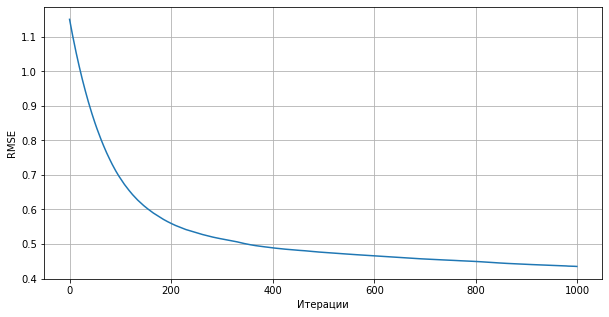

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(best_model.MSE_) ** 0.5)
plt.grid(True)
plt.ylabel('RMSE')
plt.xlabel('Итерации')
plt.show()

## Submission для соревнования

Скачаем тестовую выборку:

In [108]:
test = pd.read_csv('/content/data/test.csv')

Выведим первые 5 строк тестовой выборки:

In [109]:
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
2,37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
3,37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
4,37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


Предсказание модели градиентного бустинга на тестовой выборке:

In [110]:
y_test = best_model.predict(test[X])

Запишем предсказания в столбец `MedHouseVal`:

In [111]:
test['MedHouseVal'] = y_test

Запишем таблицу в файл для отправки решения на Kaggle:

In [112]:
test[['id', 'MedHouseVal']].to_csv('submission.csv', index=None)

### Результаты соревнования

#### Решение было подготовлено 23 марта 2023 г. Соревнование закрыто, поэтому свое место можно узнать, только сравнив свой score с итоговой доской лидеров соревнования: 420 место из 689 со `score = 0.57425`. Score лидера соревнования `=0.55224`.